In [89]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.stats.multitest

# Анализ результатов АБ-теста
В данном задании вам нужно будет

1. проанализировать АБ тест, проведенный на реальных пользователях Яндекса
2. подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
3. определить характер этих изменений и практическую значимость вводимого изменения
4. понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:
1. userID: уникальный идентификатор пользователя
2. browser: браузер, который использовал userID
3. slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
4. n_clicks: количество кликов, которые пользоваль совершил за n_queries
5. n_queries: количество запросов, который совершил userID, пользуясь браузером browser
6. n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [22]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [23]:
exp = data[data['slot'] == 'exp'].drop('slot', axis = 1)
con = data[data['slot'] == 'control'].drop('slot', axis = 1)
a = exp['n_clicks'].values.sum()
b = con['n_clicks'].values.sum()
print("%.3f" % ((a - b) / b * 100))# (B-A)/A*100

1.614


# 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [24]:
def get_bootstrap_samples(data, n_samples): #n_samples - кол-во подвыборок 
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples #n_samples подвыборок

def stat_intervals(stat, alpha): #высчитывает доверительные интервалы
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [25]:
np.random.seed(0)

exp_med = list(map(np.median, get_bootstrap_samples(exp['n_clicks'].values, 1000)))
con_med = list(map(np.median, get_bootstrap_samples(con['n_clicks'].values, 1000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_med, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(con_med, 0.05))

median = list(map(lambda x: x[1] - x[0], zip(exp_med, con_med)))

print("95% confidence interval for the difference between medians",  stat_intervals(median, 0.05))

95% confidence interval for the ILEC median repair time: [5. 5.]
95% confidence interval for the CLEC median repair time: [4. 4.]
95% confidence interval for the difference between medians [-1. -1.]


In [26]:
exp_mean = list(map(np.mean, get_bootstrap_samples(exp['n_clicks'].values, 1000)))
con_mean = list(map(np.mean, get_bootstrap_samples(con['n_clicks'].values, 1000)))

print("95% confidence interval for the ILEC mean repair time:",  stat_intervals(exp_mean, 0.05))
print("95% confidence interval for the CLEC mean repair time:",  stat_intervals(con_mean, 0.05))

mean = list(map(lambda x: x[1] - x[0], zip(exp_mean, con_mean)))

print("95% confidence interval for the difference between medians",  stat_intervals(mean, 0.05))

95% confidence interval for the ILEC mean repair time: [11.50674915 11.65758017]
95% confidence interval for the CLEC mean repair time: [11.21242374 11.35449133]
95% confidence interval for the difference between medians [-0.40975645 -0.19866114]


# 3

In [27]:
np.random.seed(0)
n_boot_samples = 500

con_mean = list(map(np.mean, get_bootstrap_samples(con['n_clicks'].values, n_boot_samples)))
con_std = list(map(np.std,  get_bootstrap_samples(con['n_clicks'].values, n_boot_samples)))

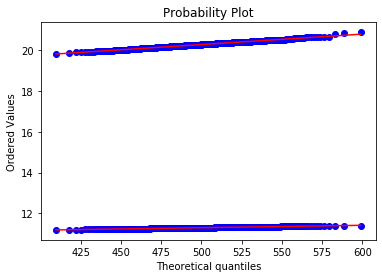

In [38]:
scipy.stats.probplot(con_mean, dist="chi2", sparams=(len(con_mean) - 1), plot=plt)
scipy.stats.probplot(con_std, dist="chi2", sparams=(len(con_std) - 1),  plot=plt)
plt.show()

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости 

In [40]:
scipy.stats.mannwhitneyu(exp['n_clicks'], con['n_clicks'])

MannwhitneyuResult(statistic=38940590204.0, pvalue=3.1236179006848145e-75)

# 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [67]:
pd.crosstab([1],exp.browser)

browser,Browser #14,Browser #17,Browser #2,Browser #20,Browser #22,Browser #4
row_0,,,,,,
1,44220,16253,54944,16931,71080,78152


In [69]:
br2 = data[data['browser'] == 'Browser #2']
br4 = data[data['browser'] == 'Browser #4']
br14 = data[data['browser'] == 'Browser #14']
br17 = data[data['browser'] == 'Browser #17']
br20 = data[data['browser'] == 'Browser #20']
br22 = data[data['browser'] == 'Browser #22']

In [94]:
p = []
for i in [br2, br4, br14, br17, br20, br22]:
    p.append(scipy.stats.mannwhitneyu(i[i['slot'] == 'exp'].n_clicks,  i[i['slot'] == 'control'].n_clicks)[1])

ref, p, a1, a2 = statsmodels.stats.multitest.multipletests(p, 0.05, method='holm')
len(ref) - ref.sum()

5